# Regresión Logística

Uno de los modelos de clasificación más simples que existe, el modelo de regresión logística consiste en una red neuronal de una celda cuya función de activación es la logística:

$$
\sigma: \mathbb{R} \to (0,1) \; / \;\sigma(z) = \frac{1}{1+e^{-z}}
$$


Imagen de wikipedia:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1280px-Logistic-curve.svg.png)

En particular, una propiedad interesante que tiene la sigmoidea es que $\sigma ' (z)= \sigma(z)(1-\sigma(z))$, lo que la hace fácil de computar si se guarda el último valor de salida $\sigma(z)$.


Reemplazando con $z = w^T \cdot x + b$ una transformación afín del vector de entrada $x$ vía el vector de pesos $w$ y el sesgo $b$, se obtiene que el modelo $h(x)$ es

$$
h(x) = \sigma(w^T  \cdot x+b) = \frac{1}{1+e^{-(w^T  \cdot x+b)}}
$$

cuya salida es un valor entre 0 y 1, interpretable a su vez en un esquema de clasificación binaria (las clases posibles son $0$ y $1$) como *la probabilidad de que ese $x$ pertenezca a la clase 1*.


Los parámetros del modelo son $w \in \mathbb{R}^{p}$ y $b \in \mathbb{R}$, suponiendo que la entrada es un vector de $p$ *features* $x \in \mathbb{R}^{p}$.


## Función de pérdida

Por conveniencia se usa la *cross-entropy loss*:

$$
\mathcal{L}(y,\hat{y}) = -y \cdot log(\hat{y}) - (1-y) \cdot log(1-\hat{y})
$$

Al margen de las muchas propiedades que exhibe la utilización de esa función de pérdida (cuya minimización, por ejemplo, es equivalente a maximizar la verosimilitud de los datos), su derivada resulta muy práctica por cómo se acopla con la derivada respecto de $z$:

$$
\frac{d\mathcal{L}(y,\hat{y})}{d\hat{y}} = \frac{\hat{y}-y}{\hat{y}(1-\hat{y})}
$$

## Backpropagation

Para llegar hasta $w$ y $b$ tenemos algo de este estilo:

$$
\frac{d\mathcal{L}}{dw} = \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{dz} \cdot \frac{dz}{dw}
$$

Como se vio antes, $\hat{y} = \sigma (z)$, por lo que los primeros dos términos resultan:
$$
dZ = \frac{d\mathcal{L}}{dz} = \frac{d\mathcal{L}}{d\hat{y}} \cdot \frac{d\hat{y}}{dz} = \frac{\hat{y}-y}{\hat{y}(1-\hat{y})} \cdot \hat{y}(1-\hat{y}) = \hat{y}-y
$$

Recordemos también que $w \in \mathbb{R}^{p}$ y $b \in \mathbb{R}$, o en notación numpy `w.shape = (p,1)` y `b.shape = (1,)`.

### Para `batch_size=1`

Si se pasa una sola entrada, $x \in \mathbb{R}^p$ o en notación numpy `x.shape = (p,1)`.

Luego, $z, \frac{d\mathcal{L}}{dz} \in \mathbb{R}$ o en notación numpy `z.shape = (1,)` y `dZ.shape = (1,)`.

Tenemos entonces que
$$
\frac{dz}{dw} = x, \frac{dz}{db} = 1
$$


Por lo tanto
$$
\frac{d\mathcal{L}}{dw} = (\hat{y}-y) \cdot x = dZ \cdot x
$$
y
$$
\frac{d\mathcal{L}}{db} =  \hat{y}-y = dZ
$$

### Para `batch_size > 1`

Si se pasan *m* entradas en paralelo, $x \in \mathbb{R}^{p \times m}$ o en notación numpy `x.shape = (p,m)`.

El resultado de hacer $z = w^T \cdot x + b$ y las predicciones $\hat{y} = \sigma (z)$ son entonces $z, \hat{y} \in \mathbb{R}^{1 \times m}$, o en notación numpy `z.shape = (1, m)` e `y_hat.shape = (1, m)`.

Como lo que queremos es obtener la derivada para parámetro, para cada observación, y luego promediarlas, lo que observamos es que
$$
dZ = \frac{d\mathcal{L}}{dz} = \hat{y}-y \in \mathbb{R}^{1 \times m}
$$

Si tomamos, por ejemplo, $w_1 \in \mathbb{R}$ (la primera componente de $w$), la derivada debería ser:

(observar que la primer fila de $x$, $x_{(1,:)} \in \mathbb{R}^{1 \times m}$)

$$
\frac{d\mathcal{L}}{dw_1} = \frac{1}{m} \sum_{i=1}^m (\hat{y}_i-y_i) \cdot x_{(1,i)} = \frac{1}{m} < x_{(1,:)}, dZ>
$$

$$$$
¿Con qué versión de $< x_{(1,:)}, dZ>$ nos quedamos? Con $x_{(1,:)} \cdot dZ ^ T$ o con $dZ \cdot (x_{(1,:)}) ^T$?
Respuesta: con la que cuando lo pasemos a todo el vector $w$ nos queden bien las dimensiones, porque una es la traspuesta de la otra.

Observemos que si hacemos la misma cuenta pero para todo $w$, teniendo `w.shape = (p,1)`, `x.shape = (p, m)` entonces
$$
dW = \frac{d\mathcal{L}}{dw} = \frac{1}{m} \; x \cdot dZ^T  \in \mathbb{R}^{p \times 1}
$$

En el caso de $b$ es más fácil porque el coeficiente es $\frac{d\mathcal{L}}{db} = 1$, entonces
$$
db = \frac{d\mathcal{L}}{db} = \frac{1}{m} \sum_{i=1}^m \hat{y_i}-y_i =  \frac{1}{m} \sum_{i=1}^m (\hat{y}-y)_i = \frac{1}{m} \sum_{i=1}^m dZ_i \in \mathbb{R}
$$

que en código es simplemente
```
dW = (1/m) * x @ dZ.T
db = np.mean(dZ)
```

# Código

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

Función auxiliar para la sigmoidea

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Obtenemos los datos

In [ ]:
# random seeds
rng_seed = 1234

# datos
X, y = load_breast_cancer(return_X_y=True)

# separamos en set de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng_seed)

# estandarizamos
# tip: prar qué pasa si no se estandariza
mu = X_train.mean(axis=0, keepdims=True)
s = X_train.std(axis=0, keepdims=True)

X_train = (X_train - mu) / s
X_test = (X_test - mu) / s

# trasponemos para que cada observación sea un vector columna
X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

n_dims, n_obs = X_train.shape

n_dims, n_obs

(30, 398)

Tenemos $p=30$, $n=398$ para train

In [ ]:
# miramos dimensiones para ambos X e y
X_train.shape, y_train.shape

((30, 398), (1, 398))

Para comparar métodos siempre desde el mismo punto inicial, determinamos uno

In [ ]:
# inicialización
rng = np.random.default_rng(rng_seed)

w0 = rng.standard_normal(size=(n_dims,1)) * 0.01
b0 = rng.uniform(size=1)

w0,b0

(array([[-0.01603837],
        [ 0.000641  ],
        [ 0.00740891],
        [ 0.00152619],
        [ 0.00863744],
        [ 0.02913099],
        [-0.01478823],
        [ 0.00945473],
        [-0.01666135],
        [ 0.00343745],
        [-0.00512444],
        [ 0.01323759],
        [-0.0086028 ],
        [ 0.00519493],
        [-0.01265144],
        [-0.02159139],
        [ 0.00434734],
        [ 0.01733289],
        [ 0.00520134],
        [-0.01002166],
        [ 0.00268346],
        [ 0.00767175],
        [ 0.01191272],
        [-0.01157411],
        [ 0.00696279],
        [ 0.00351384],
        [-0.00032415],
        [ 0.00013182],
        [-0.0067925 ],
        [-0.00620532]]),
 array([0.73581899]))

In [ ]:
# observamos dimensiones, ver que p=30
w0.shape, b0.shape

((30, 1), (1,))

Mostramos cómo se ve eso de samplear cuando `m = batch_sz > 1`.

En este caso, tomamos $m = 5$ para ejemplificar:

In [ ]:
# elegimos m=5 indices al azar, sin reposición
indices = rng.choice(n_obs, 5, replace = False)
indices

array([178, 384, 333, 130, 168])

In [ ]:
# obtenemos los valores de X e y correspondientes a esas columnas
x = X_train[:, indices]
y = y_train[:, indices]

x.shape, y.shape

((30, 5), (1, 5))

Armamos una función auxiliar para calcular cuánto vale $J_{test}(w,b)$

In [ ]:
# funcion auxiliar, equivalente a log_loss
def test_loss(w,b):
    z = w.T @ X_test + b
    y_hat = sigmoid(z)

    log_loss_v = y_test * np.log(y_hat) + (1-y_test)* np.log(1-y_hat)

    return -log_loss_v.mean().item()

# mostramos ejemplo antes de empezar a entrenar
test_loss(w0,b0)

0.6797365154417319

Por las dudas, creamos otra también pero con accuracy

In [ ]:
def test_acc(w,b):
    z = w.T @ X_test + b
    y_hat = sigmoid(z)

    # usamos un threshold común de 0.5
    y_pred = (y_hat > 0.5) * 1

    return (y_test == y_pred).mean().item()

# mostramos ejemplo antes de empezar a entrenar
test_acc(w0,b0)

0.6140350877192983

In [ ]:
def fit_one(n_iters, batch_sz, lr, measure_loss = True):
    # inicializamos con copia de los valores iniciales
    w = w0.copy()
    b = b0.copy()

    # si measure_loss es True medimos loss, sino accuracy
    test_f = test_loss if measure_loss else test_acc

    # iniciamos el histórico de J_test
    historic_loss = np.empty(n_iters)

    for i in range(n_iters):
        # obtenemos J_test y lo guardamos
        historic_loss[i] = test_f(w,b)

        # sampleamos una cantidad igual a batch_sz
        indices = rng.choice(n_obs, batch_sz, replace=False)
        x = X_train[:, indices]
        y = y_train[:, indices]


        # forward
        z = w.T @ x + b
        y_hat = sigmoid(z)

        # backwards
        dZ = y_hat - y

        dW = (1/batch_sz) * x @ dZ.T
        db = dZ.mean()

        # aplicamos gradient descent
        w -= lr * dW
        b -= lr * db

    # devolvemos el histórico de J_test
    return historic_loss

Corremos uno para mostrar

In [ ]:
h1 = fit_one(
    n_iters = 150,
    batch_sz = 1,
    lr = 1e-2,
    measure_loss = True
)

[]

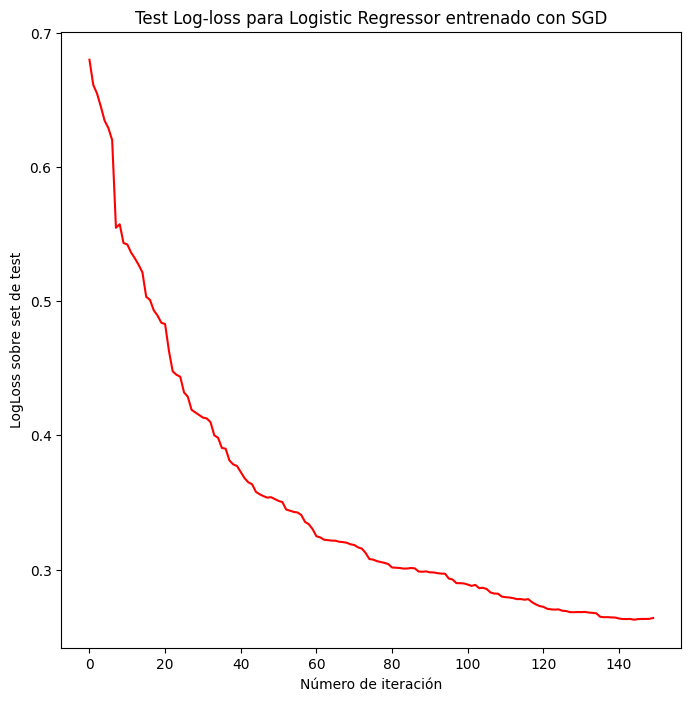

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(h1, color='red')
ax.set_title(f"Test Log-loss para Logistic Regressor entrenado con SGD")
ax.set_xlabel("Número de iteración")
ax.set_ylabel("LogLoss sobre set de test")

ax.plot()

In [ ]:
# ahora miramos accuracy
acc1 = fit_one(
    n_iters = 150,
    batch_sz = 1,
    lr = 1e-2,
    measure_loss = False
)

[]

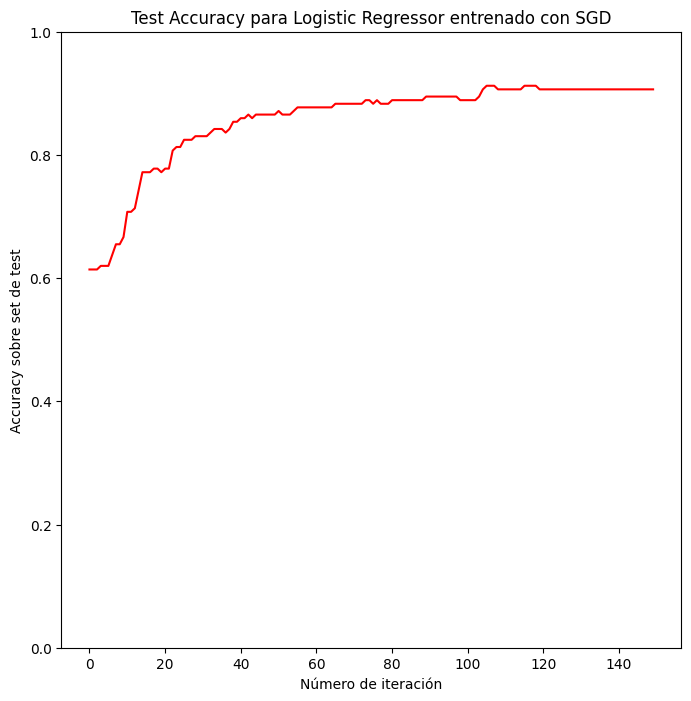

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(acc1, color='red')
ax.set_title(f"Test Accuracy para Logistic Regressor entrenado con SGD")
ax.set_xlabel("Número de iteración")
ax.set_ylabel("Accuracy sobre set de test")
ax.set_ylim(0,1)
ax.plot()

## Variabilidad de SGD

Medimos la curva de loss sobre varios

In [ ]:
historics_sgd = [fit_one(
    n_iters = 150,
    batch_sz = 1,
    lr = 1e-2,
    measure_loss = True
)
    for i in range(10)
]

[]

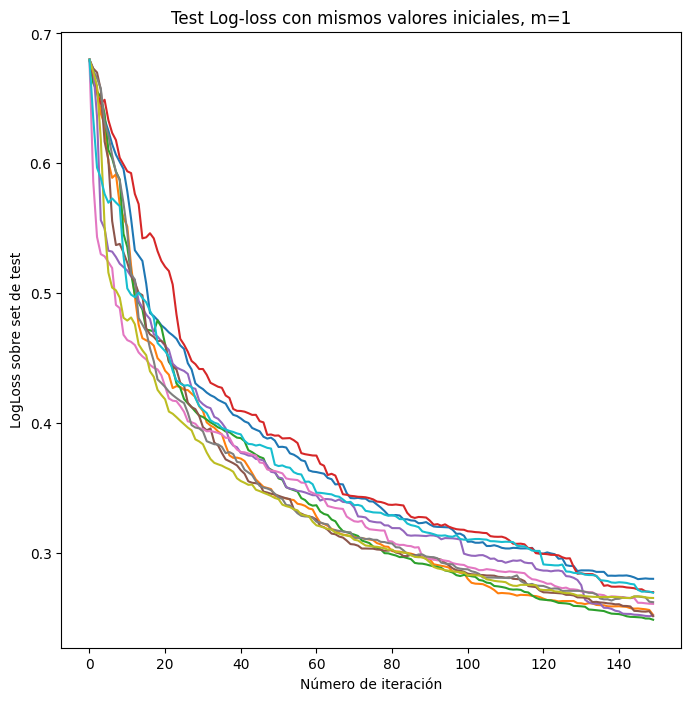

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

for h in historics_sgd:
    ax.plot(h)

ax.set_title(f"Test Log-loss con mismos valores iniciales, m=1")
ax.set_xlabel("Número de iteración")
ax.set_ylabel("LogLoss sobre set de test")

ax.plot()

## Estabilización usando $m>1$

Probamos con $m=10$

In [ ]:
historics_m10 = [fit_one(
    n_iters = 150,
    batch_sz = 10,
    lr = 1e-2,
    measure_loss = True
)
    for i in range(10)
]

[]

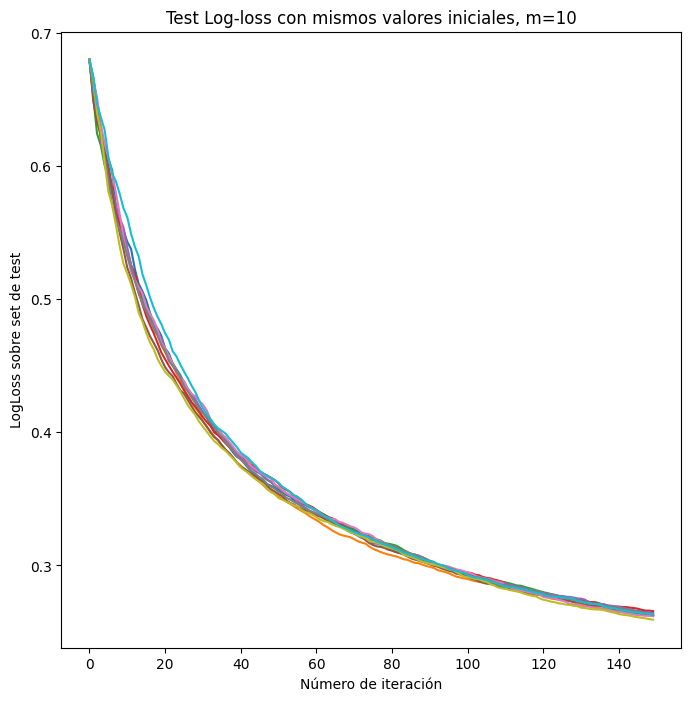

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

for h in historics_m10:
    ax.plot(h)

ax.set_title(f"Test Log-loss con mismos valores iniciales, m=10")
ax.set_xlabel("Número de iteración")
ax.set_ylabel("LogLoss sobre set de test")

ax.plot()

Ahora lo llevamos a un nivel medio extremo teniendo en cuenta que $n=398$

[]

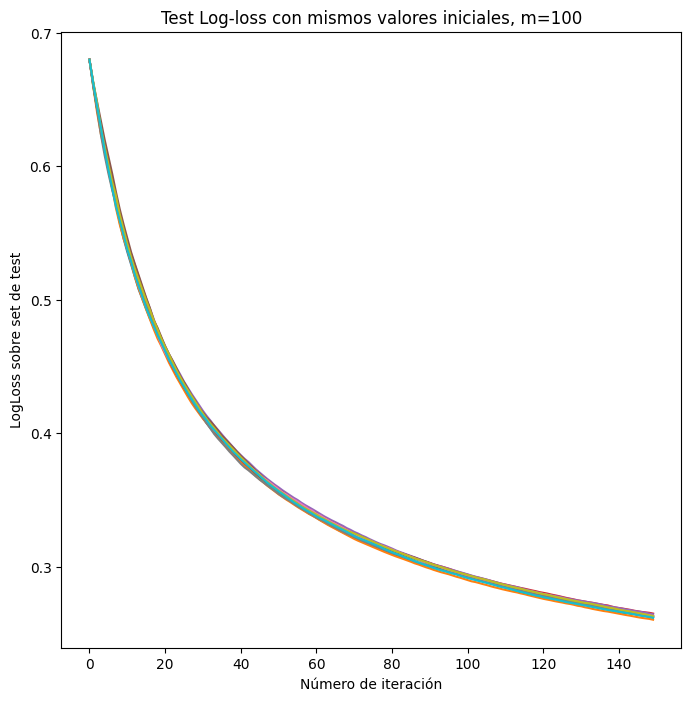

In [ ]:
historics_m100 = [fit_one(
    n_iters = 150,
    batch_sz = 100,
    lr = 1e-2,
    measure_loss = True
)
    for i in range(10)
]

fig, ax = plt.subplots(figsize=(8,8))

for h in historics_m100:
    ax.plot(h)

ax.set_title(f"Test Log-loss con mismos valores iniciales, m=100")
ax.set_xlabel("Número de iteración")
ax.set_ylabel("LogLoss sobre set de test")

ax.plot()

## Wall clock vs iteration speed

Imaginemos que cada forward se hacía de forma secuencial, de manera que hacer 10 forwards lleva 10 veces el tiempo de un backwards. Entonces, una iteración con $m=10$ llevaría (aprox) 10 veces el tiempo de $m=1$.

¿Cómo se vería eso en el gráfico de losses por iteración?

[]

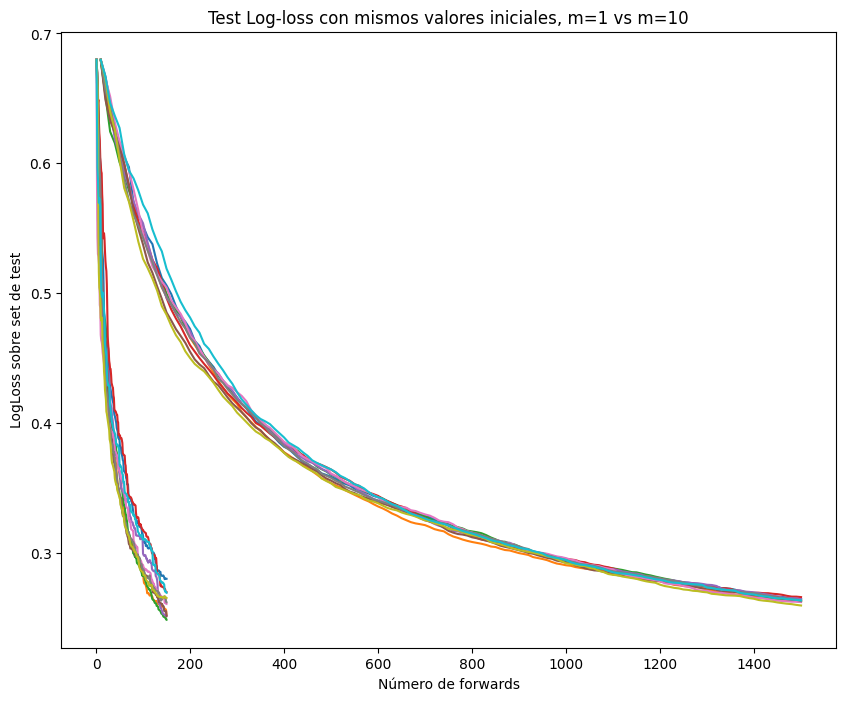

In [ ]:
n_fws = np.arange(150) + 1

fig, ax = plt.subplots(figsize=(10,8))

for h in historics_sgd:
    ax.plot(n_fws, h)

for h in historics_m10:
    ax.plot(n_fws * 10, h)

ax.set_title(f"Test Log-loss con mismos valores iniciales, m=1 vs m=10")
ax.set_xlabel("Número de forwards")
ax.set_ylabel("LogLoss sobre set de test")

ax.plot()

Conclusión: la estabilidad que brinda la mejor estimación es positiva siempre y cuando el tiempo de iteración no se vea afectado.